In [1]:
import pandas as pd

In [2]:
#leemos los datos
#dt = pd.read_csv('../data/recorridos-realizados-2019.csv',nrows=1000)
dt = pd.read_csv('../data/recorridos-realizados-2019.csv')
dt['id_estacion_origen'] = pd.to_numeric(dt.id_estacion_origen\
                                     .str.replace('_','.'))
dt['id_estacion_destino'] = pd.to_numeric(dt.id_estacion_destino\
                                     .str.replace('_','.'))
dt.head()

/home/pipe/Documents/untref/analisis_espacial_python_2019/vevn/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,4,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id_usuario,fecha_origen_recorrido,duracion_recorrido,nombre_estacion_origen,id_estacion_origen,nombre_estacion_destino,id_estacion_destino,genero_usuario,edad_usuario,fecha_destino_recorrido
0,115783_0,2019-01-01 00:01:16,0 days 00:07:02.000000000,Estados Unidos,168.0,9 de Julio,112.0,FEMENINO,36.0,2019-01-01 00:08:18
1,345364_0,2019-01-01 00:04:32,0 days 00:05:33.000000000,Colegio Nacional Buenos Aires,47.0,Colegio Nacional Buenos Aires,47.0,MASCULINO,40.0,2019-01-01 00:10:05
2,570578_0,2019-01-01 00:09:15,0 days 00:19:45.000000000,Pueyrredón,144.0,Ecoparque,44.0,FEMENINO,41.0,2019-01-01 00:29:00
3,588687_0,2019-01-01 00:09:28,0 days 00:19:34.000000000,Pueyrredón,144.0,Ecoparque,44.0,MASCULINO,43.0,2019-01-01 00:29:02
4,127201_0,2019-01-01 00:11:17,0 days 00:21:32.000000000,Legislatura,16.0,EEUU y Boedo,199.0,MASCULINO,33.0,2019-01-01 00:32:49


In [3]:
#obtenemos una tabla con cantidad de viajes por cada estacion de origen
viajesXestacion = dt.reindex(columns = ['id_estacion_origen','id_usuario'])\
                    .groupby('id_estacion_origen').count().reset_index()
viajesXestacion.columns = ['id_estacion_origen','n']
viajesXestacion.sort_values(by='n',ascending=False).head(3)

,id_estacion_origen,n
7,9.0,4361
11,14.0,4050
6,8.0,3482


In [4]:
#leemos el shape con los objetos geometricos de nuestras estaciones
estaciones = pd.read_csv('../carto/estaciones-bicicletas.csv')
estaciones = estaciones.reindex(columns = ['lat','long','nombre_estacion','id_estacion'])
estaciones.head()

,lat,long,nombre_estacion,id_estacion
0,-34.592423,-58.374715,002 - Retiro I,2
1,-34.611032,-58.368260,003 - ADUANA,3
2,-34.601726,-58.368763,004 - Plaza Roma,4
3,-34.580550,-58.420954,005 - Plaza Italia,5
4,-34.628526,-58.369758,006 - Parque Lezama,6


In [5]:
#importamos la funcion para crear puntos de la libreria de shapely
from shapely.geometry import Point


In [6]:
#definimos una funcion que cree un Shapely Point a partir de un par de latlong
def crear_punto(lat,long):
    #noten como se invierte el orden tradicional de latlong, para ser long lat similar al orden matematico x,y
    return Point(long,lat)

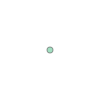

In [7]:
#probamos la funcion
crear_punto(long = estaciones.iloc[0].long,
            lat = estaciones.iloc[0].lat)

In [8]:
#iteramos a traves de todo nuestro dataset de estacoines y guardamos en una lista sus pares latlong como Points
lista = []
for i in estaciones.index:
    punto = crear_punto(long = estaciones.loc[i].long,
            lat = estaciones.loc[i].lat)
    lista.append(punto)
lista

In [9]:
#importamos geopandas
import geopandas as gpd

In [10]:
#convertimos nuestro DataFrame de estaciones en un GeoDataFrame
crs = {'init' :'epsg:4326'}
gdf = gpd.GeoDataFrame(estaciones,
                       geometry=lista,
                       crs={'init' :'epsg:4326'})
gdf.head()


,lat,long,nombre_estacion,id_estacion,geometry
0,-34.592423,-58.374715,002 - Retiro I,2,POINT (-58.37472 -34.59242)
1,-34.611032,-58.368260,003 - ADUANA,3,POINT (-58.36826 -34.61103)
2,-34.601726,-58.368763,004 - Plaza Roma,4,POINT (-58.36876 -34.60173)
3,-34.580550,-58.420954,005 - Plaza Italia,5,POINT (-58.42095 -34.58055)
4,-34.628526,-58.369758,006 - Parque Lezama,6,POINT (-58.36976 -34.62853)


In [11]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

In [12]:
#importamos las librerias de visualizacion
import matplotlib.pyplot as plt
%matplotlib inline

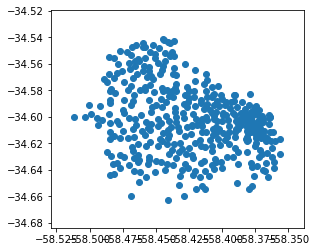

In [13]:
#visualizamos nuestras estaciones
gdf.plot()

In [14]:
#vemos que porcentajes de nuestras estaciones con viajes esta en nuestro shapefile
viajesXestacion.id_estacion_origen.isin(estaciones.id_estacion).sum() / len(viajesXestacion)

0.8426966292134831

In [15]:
#hacemos el merge en base a las columnas que actuan como clave
gdf = gdf.merge(viajesXestacion,
                              left_on = 'id_estacion',
                              right_on = 'id_estacion_origen',
                              how = 'inner'
                             )

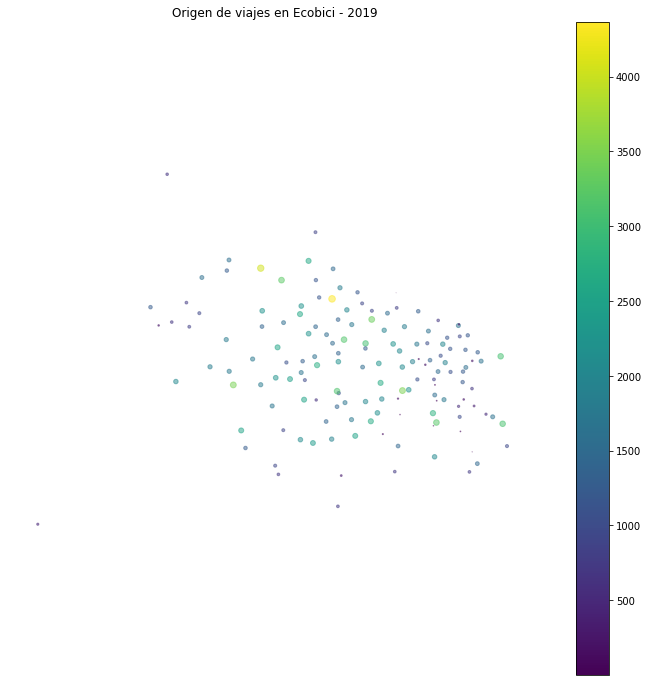

In [16]:
#creamos un plot que muestre el origen mas popular
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1)
gdf.plot(ax=ax,column='n',
                markersize=gdf['n']/100,
                alpha=0.5,legend=True) 
ax.set_axis_off()
plt.axis('equal')
ax.set_title('Origen de viajes en Ecobici - 2019');

In [17]:
#creamos un viaje agrupando por origen como destino, lo que nos da el par Origen-Destino de un viaje
viajes = dt.reindex(columns = ['id_estacion_origen','id_estacion_destino','id_usuario'])\
                    .groupby(['id_estacion_origen','id_estacion_destino']).count().reset_index()
viajes.columns = ['id_estacion_origen','id_estacion_destino','n']
viajes.sort_values(by='n',ascending=False).head(3)

,id_estacion_origen,id_estacion_destino,n
2924,26.0,26.0,804
16595,150.0,150.0,754
3340,29.0,29.0,753


In [18]:
#usamos como indice el indice verdadero
estaciones.index = estaciones.id_estacion
estaciones.head()

,lat,long,nombre_estacion,id_estacion,geometry
id_estacion,,,,,
2,-34.592423,-58.374715,002 - Retiro I,2,POINT (-58.37472 -34.59242)
3,-34.611032,-58.368260,003 - ADUANA,3,POINT (-58.36826 -34.61103)
4,-34.601726,-58.368763,004 - Plaza Roma,4,POINT (-58.36876 -34.60173)
5,-34.580550,-58.420954,005 - Plaza Italia,5,POINT (-58.42095 -34.58055)
6,-34.628526,-58.369758,006 - Parque Lezama,6,POINT (-58.36976 -34.62853)


In [19]:
#importamos la funcion LineString
from shapely.geometry import LineString

In [20]:
#nos quedamos solo con los viajes cuyas estacinoes tenemos en el shape
viajes = viajes.loc[viajes.id_estacion_origen.isin(estaciones.index) &
                    (viajes.id_estacion_destino.isin(estaciones.index)),:]

In [21]:
#producimos una linea con el origen destino
geometrias = []
for indice,fila in viajes.iterrows():
    
    id_origen = fila.id_estacion_origen
    id_destino = fila.id_estacion_destino 
    
    punto_origen = [estaciones.loc[id_origen,'long'],\
                    estaciones.loc[id_origen,'lat']]
    punto_destino = [estaciones.loc[id_destino,'long'],\
                     estaciones.loc[id_destino,'lat']]
    
    linea = LineString([punto_origen,punto_destino])
    
    geometrias.append(linea)

In [22]:
#convertimos nuestro dataFrame en un geoDataFrame
viajes = gpd.GeoDataFrame(viajes,
                          geometry  = geometrias,
                          crs={'init' :'epsg:4326'})
viajes.head()

,id_estacion_origen,id_estacion_destino,n,geometry
134,2.0,2.0,141,"LINESTRING (-58.37472 -34.59242, -58.37472 -34..."
135,2.0,4.0,68,"LINESTRING (-58.37472 -34.59242, -58.36876 -34..."
136,2.0,5.0,28,"LINESTRING (-58.37472 -34.59242, -58.42095 -34..."
137,2.0,6.0,20,"LINESTRING (-58.37472 -34.59242, -58.36976 -34..."
138,2.0,7.0,3,"LINESTRING (-58.37472 -34.59242, -58.38110 -34..."


In [23]:
estaciones=gpd.GeoDataFrame(estaciones,geometry='geometry',crs={'init' :'epsg:4326'})

In [24]:
comunas = gpd.read_file('../carto/CABA_comunas.geojson')
comunas.crs

{'init': 'epsg:4326'}

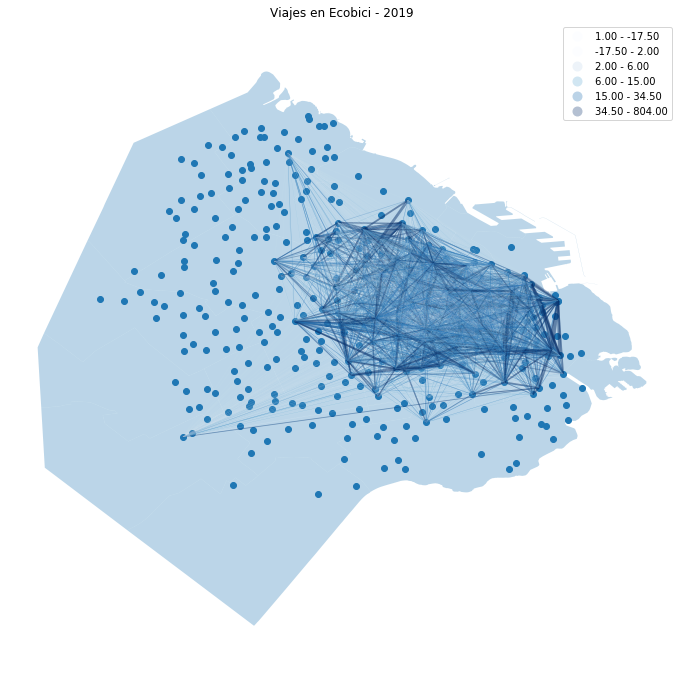

In [31]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1)

comunas.plot(ax=ax,alpha=0.3)
estaciones.plot(ax=ax)
viajes.plot(
        ax=ax,
        column = viajes['n'],
        linewidth=viajes['n']/40,
        alpha=0.3,
        cmap='Blues',    
        scheme='boxplot',
        legend=True) 
    
ax.set_axis_off()
plt.axis('equal')
ax.set_title('Viajes en Ecobici - 2019');

In [26]:
viajes.to_file('../carto/ecobici')